pyCCF
=====

A Brief Introduction to pyCCF
-----------------------------

The next module in pyPetal is pyCCF, an algorithm to compute the (interpolated) cross-correlation function and its corresponding centroid/peak. This algorithm is based on the method described in <cite data-cite="peterson_uncertainties_1998">Peterson et al. (1998)</cite>, utilized in the pyCCF package <cite data-cite="sun_pyccf_2018">Sun et al. (2018)</cite>. The pyCCF module uses the exact same software as <cite data-cite="sun_pyccf_2018">Sun et al. (2018)</cite>, updated for use in Python 3. 

.. note:: This is a brief overview of the pyCCF algorithm. For a more in-depth explanation of the concepts and methods involved, please see the pyCCF code and documentation <cite data-cite="sun_pyccf_2018">Sun et al. (2018)</cite>.

For a brief explanation, the cross-correlation function (CCF) describes the correlation of two time-series data as a function of time lag $\tau$:

$F_{CCF}(\tau) = \frac{1}{N} \sum^{N}_{i=1} \frac{[L(t_i) - \bar{L}][C(t_i - \tau) - \bar{C}]}{\sigma_C \sigma_L}$

where $N$ is the number of data points in the continuum $C$ and emission line $L$ light curves. Each light curve has a corresponding mean value $(\bar{C}, \bar{L})$ and uncertainty $(\sigma_C, \sigma_L)$

In many cases, the light curves are not well-sampled enough to grant a high quality CCF, and therefore a highly uncertain time lag. To increase the quality of the time lag estimate, the CCF can be interpolated using a linear piecewise function, with a specified interpolation distance between data points. 

Using only one realization of the interpolated cross-correlation function (ICCF) would be highly dependent on the interpolated points between the observed data, as well as the chosen resolution of the ICCF (i.e. the interpolation distance). To measure the uncertainty in the ICCF, two methods can be used to generate Monte Carlo simulations to get a distribution of the ICCF as a function of lag:

* __Flux Randomization (FR)__: The values of the light curves are sampled assuming the observed values are normally distributed with a mean of the observed value and a standard deviation of the observed uncertainty. Each realization generates a different set of light curves, which produce a slighty different ICCF.

* __Random Subset Selection (RSS)__: The light curves are randomly sampled with replacement, preserving the order of points in the light curve. Each realization of light curves generates an ICCF from a different subset of the original light curves.

The pyCCF algorithm (can) combine both FR and RSS to produce many different realizations of the ICCF. Each realization can then produce a centroid and a peak. The combined sample of centroids and peaks produces a cross-correlation centroid distribution (CCCD) and cross-correlation peak distribution (CCPD). Additionally, the algorithm produces the median ICCF.

Since the pyCCF algorithm can only be run on two light curves, and PETL accepts more than two light curves as inputs, PETL will perform pyCCF on the comntinuum and every other light curve input. Therefore, the module will produce an output for every "line" (i.e. every light curve besides the first).

pyCCF Arguments
-----------------------

The pyCCF module has the same arguments as the original pyCCF code:

__pyCCF options__

* ``interp``: The interval with which pyCCF will interpolate light curves to form the ICCF. This value must be shorter than the average cadence of the light curves. If set to ``None``, will be set to half of the average cadence of the light curves. Default is 2.

.. warning:: Setting this value too low can introduce noise.

* ``nsim``: The number of MC simulations to run. Default is 3000.

* ``mcmode``: The type of resampling to do for the MC simulations. 0 performs both FR and RSS, 1 performs only FR, and 2 performs only RSS. Default is 0.

* ``sigmode``: The threshold for considering a measurement in the ICCF significant when computing the peaks and centroids. All peaks and centroids with correlation coefficient $r_{max} \leq$ sigmode will be considered as "failed". If set to 0, will exclude all peaks based on a p-value significance test (see pyCCF documentation). Default is 0.2.

.. warning:: Must be within the interval [0,1].

* ``thres``: The lower limit of the correlation coefficient when calculating the peak and centroid of the ICCF. Default is 0.8.

.. warning:: Must be within the interval [0,1].





__Miscellanious options__

* ``nbin``: The number of bins to use for the CCCD and CCPD plots. Default is 100.

Using the pyCCF Module
-----------------------

Now, we can use the pyCCF module on an example set of light curves. We'll be using the light curves given in the pyCCF code itself. 

We'll also restrict the range that pyCCF will use to search for the lag in the CCCD and CCPD. This is specified in the general argument ``lag_bounds``. In general, this can be specified as an array of bounds, one for each line. If only one set of bounds is given, it will be used for all lines.

In [1]:
import pypetal.pipeline as pl 

main_dir = 'pypetal/examples/dat/pyccf_'
filenames = [ main_dir + 'lc1.dat', main_dir + 'lc2.dat' ]

output_dir = 'pyccf_out/'
line_names = ['Continuum', 'H-alpha']


Running pyCCF
-----------------
lag_bounds: [[-50, 100]]
interp: 2.0000000001
nsim: 2000
mcmode: 0
sigmode: 0.3
thres: 0.8
nbin: 110
-----------------
        
Failed centroids:  0
Failed peaks:  0


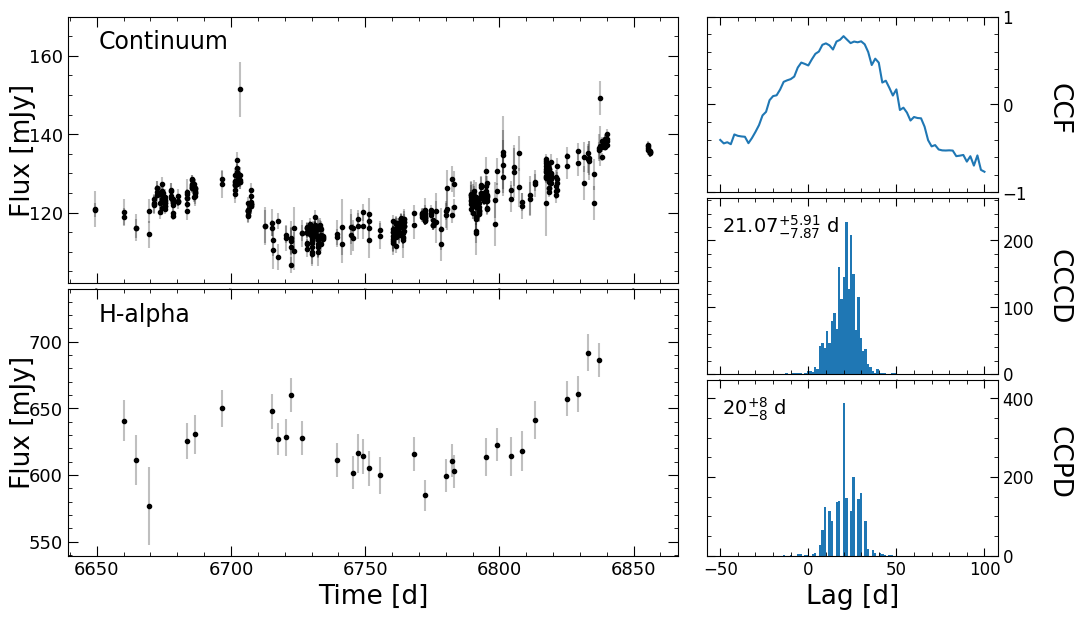

In [2]:
params = {
    'nsim': 2000,
    'sigmode': 0.3,
    'nbin': 110
}

res = pl.run_pipeline( output_dir, filenames, line_names,
                 run_pyccf=True,
                 pyccf_params=params,
                 verbose=True,
                 plot=True,
                 time_unit='d',
                 lc_unit='mJy',
                 file_fmt='ascii',
                 lag_bounds=[-50,100])

Looking at the figure, we can see the two input light curves, and all outputs of the pyCCF algorithm: the ICCF, the CCCD, and the CCPD. The values shown for the CCCD and CCPD are the median values with the upper (lower) uncertainty being the difference between the median and the $84^{th}$ $(16^{th})$ percentile of the distribution.

pyCCF Output Files
-------------------

The pyCCF module will output a number of diagnostic figures and files for each continuum/line combination. The files will always be placed into the subdirectory corresponding to the line (instead of the continuum) in the ``pyccf`` subdirectory. These outputs are:

* ``(name)_ccf_dists.dat``: All values of the centroid and peak of the ICCF for each MC simulation, used to construct the CCCD and CCPD.
* ``(name)_ccf.dat``: The median ICCF, and the lags it is measured at.
* ``(name)_ccf.pdf``: The output summary figure.

where ``(name)`` is the name of the line.

pyCCF Output Dict
------------------

The pyCCF module will output a number of data products from its analysis in a ``dict``. This ``dict`` will be located in the total output ``dict`` under the key ``pyccf_res``.

If multiple lines are input, the pyCCF module will output a list of ``dicts``, one for each line.

This output ``dict`` will have the following keys:

* ``CCF``: The output cross-correlation function.

* ``CCF_lags``: The lags corresponding to the CCF.

* ``centroid``: The median of the CCCD.

* ``centroid_err_lo``: The lower error on the centroid.

* ``centroid_err_hi``: The upper error on the centroid.

* ``peak``: The median of the CCPD.

* ``peak_err_lo``: The lower error on the peak.

* ``peak_err_hi``: The upper error on the peak.

* ``CCCD_lags``: The lags corresponding to the CCCD.

* ``CCPD_lags``: The lags corresponding to the CCPD.

* ``name``: The name of the line.

.. bibliography::